# Task 3

## Import the necessary libraries

In [1]:
import numpy as np
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
from random import random
from VAE_Classes import *

2022-12-08 14:59:20.932017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the data and split into train and test sets, and then normalize them

In [2]:
# Load
train, test = load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

In [3]:
# Normalize
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

## Build the encoder and decoder

In [4]:
def build_encoder(latent_dim):
    """ Construct the encoder network

    Args:
        latent_dim: int

    Returns: 
        keras.model
          
    """
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Flatten()(encoder_inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder") 

In [5]:
encoder = build_encoder(latent_dim=2)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                            

2022-12-08 14:59:30.230860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def build_decoder(latent_dim):
    """ Construct the decoder network.

    Args:
        latent_dim: int

    Returns: 
        keras.model
          
    """
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(256,activation="relu")(latent_inputs)
    x = layers.Dense(256,activation="relu")(x)
    x = layers.Dense(784)(x)
    decoder_outputs = layers.Reshape((28, 28, 1))(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [7]:
decoder = build_decoder(latent_dim=2)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 256)               768       
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


## Fit the training data

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(0.001))
history = vae.fit(x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 5s 8ms/step - loss: 437.9921 - reconstruction_loss: 382.1429 - kl_loss: 4.5654
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 356.0566 - reconstruction_loss: 343.1577 - kl_loss: 4.5435
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 319.9463 - reconstruction_loss: 313.9821 - kl_loss: 4.3897
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 311.0436 - reconstruction_loss: 303.5774 - kl_loss: 4.4520
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 301.1155 - reconstruction_loss: 291.3778 - kl_loss: 4.4259
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 289.8606 - reconstruction_loss: 283.2222 - kl_loss: 4.5629
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 285.0033 - reconstruction_loss: 278.6966 - kl_loss: 4.5980
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - l

## Task 3.3 (a) - Plot the latent representations

In [9]:
def plot_label_clusters(vae, data, labels):
    """ Plot latent representations.

    Args:
        data: numpy.ndarray
        labels: numpy.ndarray
          
    """
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

313/313 [==============================] - 1s 1ms/step


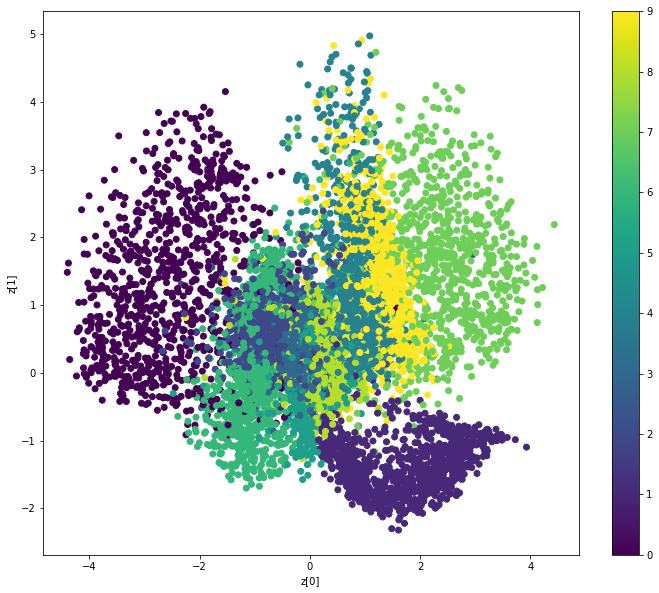

In [10]:
plot_label_clusters(vae, x_test, y_test)

## Task 3.3 (b) - Reconstruct 15 test images

In [11]:
def plot_images(images, columns, rows):
    """ Plot the given images with subplots.

    Args:
        columns: int
        rows: int
          
    """
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, columns*rows+1):
        img = images[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

In [12]:
# Store the imgs in a list to plot them later
reconstructed_and_original_images = [_]

imgs = x_test[:15]
for i in imgs:
    # Reconstruct img
    r = vae.decoder.predict(vae.encoder.predict(i)[2])
    # Append the reconstructed and corresponding original img to the list
    reconstructed_and_original_images.append(r[0])
    reconstructed_and_original_images.append(i)

1/1 [==============================] - 0s 19ms/step


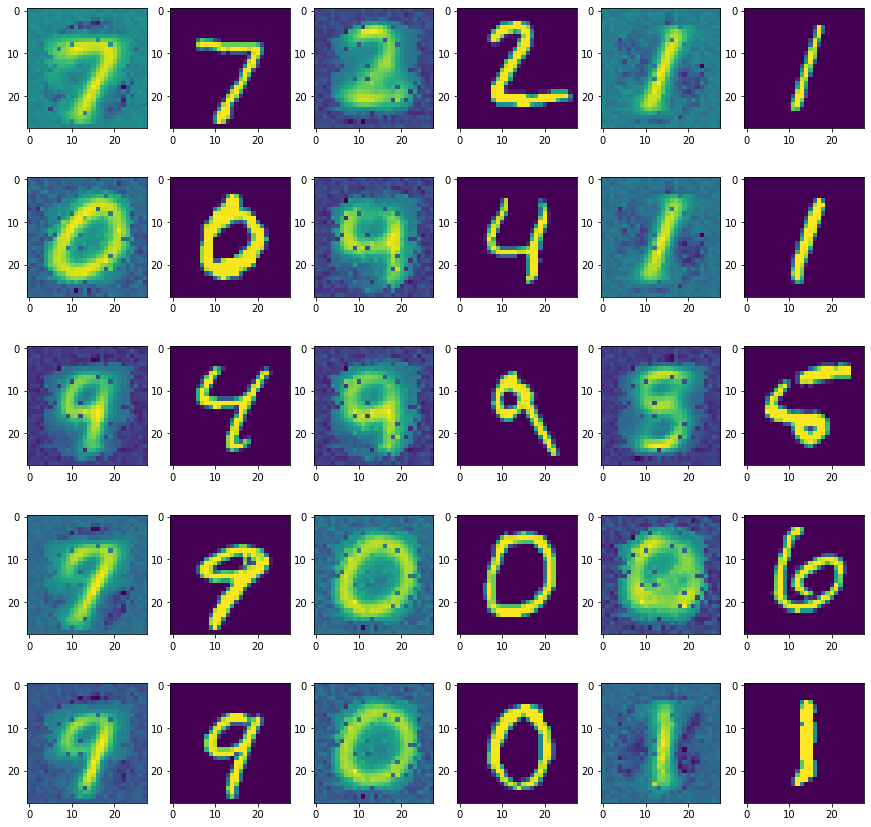

In [13]:
plot_images(reconstructed_and_original_images, 6, 5)

## Task 3.3 (c) - Generate 15 digits

In [14]:
# Generate digits
generated_digits = [_]
for i in range(15):
    z_generated =[list(np.random.normal(0, 1, 2))]
    print(z_generated)
    img = vae.decoder.predict(z_generated)
    generated_digits.append(img[0])

[[-0.14911606619994483, -0.13266445704980329]]
1/1 [==============================] - 0s 43ms/step
[[-1.6043340352468702, 0.7867140913343685]]
1/1 [==============================] - 0s 31ms/step
[[-0.31283065712974845, 0.08698473734063988]]
1/1 [==============================] - 0s 43ms/step
[[0.09712754743114074, 1.2553934178473567]]
1/1 [==============================] - 0s 34ms/step
[[-1.0149020315426511, -0.48941405485153405]]
1/1 [==============================] - 0s 30ms/step
[[-2.1899761662653603, -0.06921966994873119]]
1/1 [==============================] - 0s 29ms/step
[[0.820670293093915, -3.3801347380627313]]
1/1 [==============================] - 0s 32ms/step
[[0.09546013300994091, 0.2705495578598557]]
1/1 [==============================] - 0s 28ms/step
[[0.10898060213177647, -0.7294091121224384]]
1/1 [==============================] - 0s 32ms/step
[[0.8342960228052452, -0.35805651747042777]]
1/1 [==============================] - 0s 29ms/step
[[-0.08805216551170848, -0.411

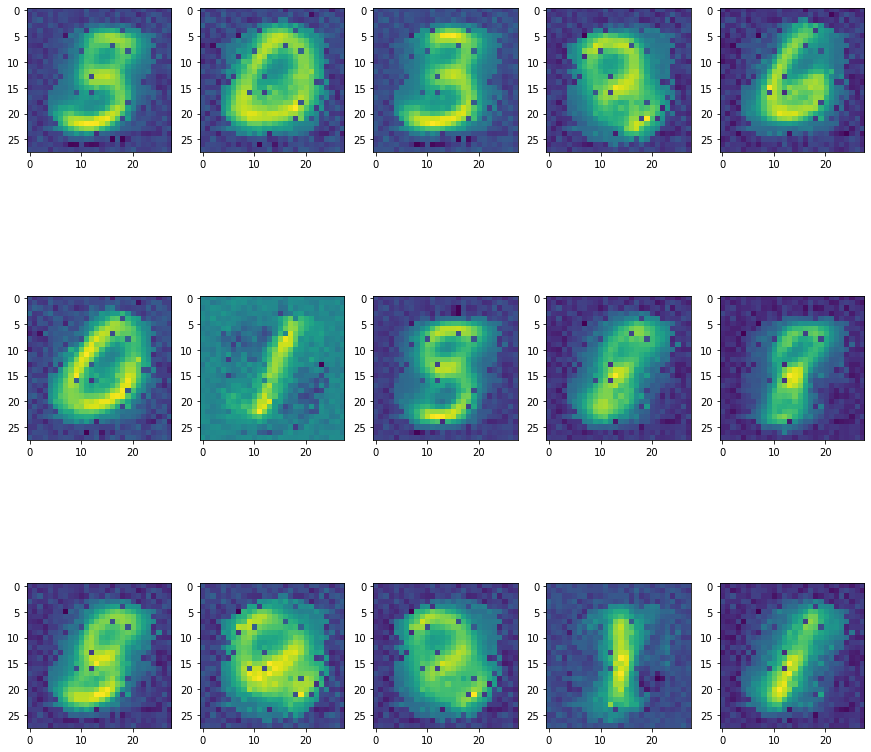

In [15]:
plot_images(generated_digits, 5,3)

## Task 3.4 - Plot the loss curve for 2-dim latent space network

In [16]:
def plot_loss_curve(history, title):
    """ Plot the loss curve.

    Args:
        history: keras.callbacks.History
        title: str
          
    """
    plt.plot(history.history['loss'])
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss'], loc='upper right')
    plt.show()

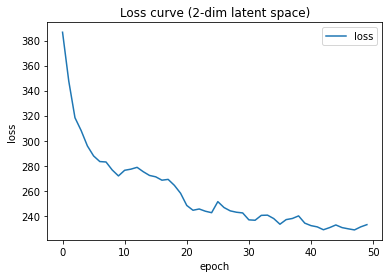

In [17]:
plot_loss_curve(history, title="Loss curve (2-dim latent space)")

## Task 3.5 (a) - Generate 15 digits with 32-dimensional latent space network

In [18]:
# Build encoder
encoder2 = build_encoder(latent_dim=32)
encoder2.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 256)          200960      ['flatten_1[0][0]']              
                                                                                                  
 dense_6 (Dense)                (None, 256)          65792       ['dense_5[0][0]']                
                                                                                            

In [19]:
# Build decoder
decoder2 = build_decoder(latent_dim=32)
decoder2.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_7 (Dense)             (None, 256)               8448      
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 784)               201488    
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 275,728
Trainable params: 275,728
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fit the training data
vae2 = VAE(encoder2, decoder2)
vae2.compile(optimizer=keras.optimizers.Adam(0.001))
history2 = vae2.fit(x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 5s 8ms/step - loss: 283.3934 - reconstruction_loss: 222.2860 - kl_loss: 12.2951
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 210.3203 - reconstruction_loss: 192.4588 - kl_loss: 18.2627
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 213.1982 - reconstruction_loss: 187.4194 - kl_loss: 18.4867
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 214.0494 - reconstruction_loss: 189.7349 - kl_loss: 20.6513
Epoch 5/50
469/469 [==============================] - 8s 17ms/step - loss: 199.0958 - reconstruction_loss: 180.7395 - kl_loss: 18.2802
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 200.5855 - reconstruction_loss: 178.6325 - kl_loss: 18.2088
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 192.1922 - reconstruction_loss: 175.3596 - kl_loss: 16.6962
Epoch 8/50
469/469 [==============================] - 4s 8ms

1/1 [==============================] - 0s 28ms/step


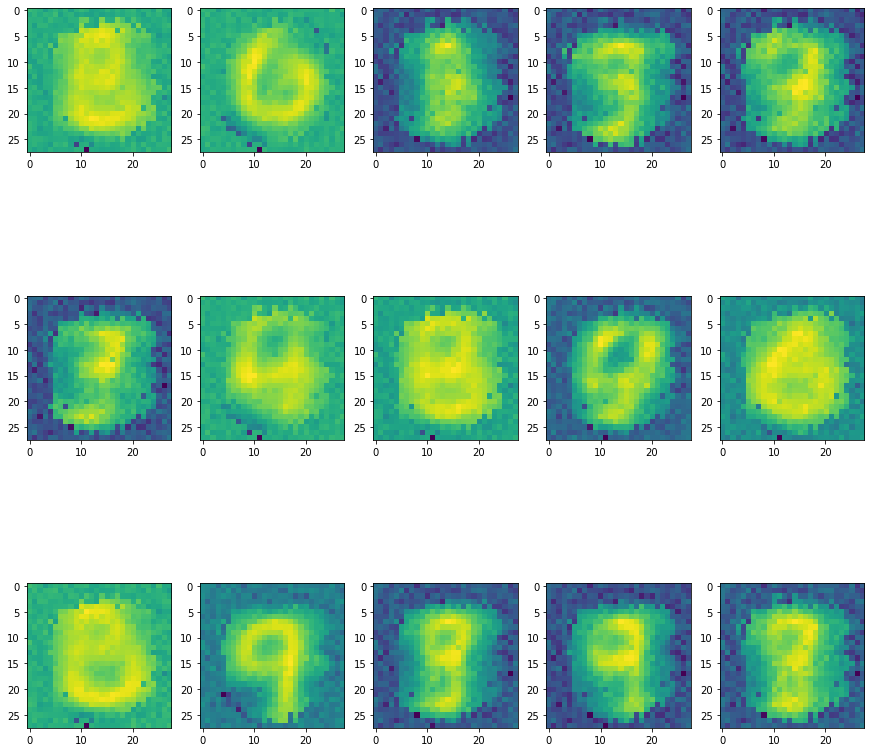

In [21]:
# Generate 15 digits

generated_digits2 = [_]
for i in range(15):
    z_generated = [list(np.random.normal(0, 1, 32))]
    img = vae2.decoder.predict(z_generated)
    generated_digits2.append(img[0])

plot_images(generated_digits2, 5,3)

## Task 3.5 (b) - Plot the loss curve for 32-dimensional latent space

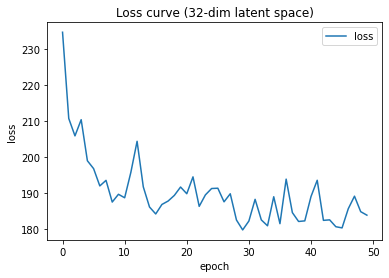

In [22]:
plot_loss_curve(history2, title="Loss curve (32-dim latent space)")